In [1]:
from dataset import *
from train import *


In [2]:
import os
import pandas as pd

import torch
import torch.optim as optim

In [32]:
# Set parameters
EuroSat_Type = 'ALL'    
target_country = 'France'

lr = 0.01               # learn_rate
milestones = [50,75,90] # multistep scheduler
epochs = 100            # no of epochs

output_path = "./" + target_country

## Download data

In [33]:
# raw data
if EuroSat_Type == 'RGB':
  data_folder = '/content/sample_data/'
  #root = os.path.join(data_folder, '2750/')
  root = '2750/'
  download_ON = os.path.exists(root)

  if not download_ON:
    # This can be long...
    #os.chdir(data_folder)
    os.system('wget http://madm.dfki.de/files/sentinel/EuroSAT.zip') #Just RGB Bands
    !unzip EuroSAT.zip
    download_ON = True
elif EuroSat_Type == 'ALL':
    root = 'ds/images/remote_sensing/otherDatasets/sentinel_2/tif/'
    download_ON = os.path.exists(root)
    if not download_ON:
      os.system('wget http://madm.dfki.de/files/sentinel/EuroSATallBands.zip') #All bands
      !unzip EuroSATallBands.zip
      download_ON = True
    
data = torchvision.datasets.DatasetFolder(root=root,loader = iloader, transform=None, extensions = 'tif')

In [34]:
# Metadata
geo_df = pd.read_csv("metadata.csv")
geo_dict = geo_df.to_dict()
countries = list(set(geo_dict["country"].values()))
id_countries = dict.fromkeys(countries)
for k in id_countries.keys():
    id_countries[k] = [v for (i, v) in enumerate(geo_dict["id"]) if geo_dict["country"][i] == k]

In [35]:
# source - target split
id_target = id_countries[target_country]
id_train = random.sample(id_target, 320)
id_test = list(set(id_target) - set(id_train))[0:160]

loader_target_train = torch.utils.data.DataLoader(torch.utils.data.Subset(data, id_train), 
                                                  batch_size= 16, shuffle=False, num_workers=0)
loader_target_test = torch.utils.data.DataLoader(torch.utils.data.Subset(data, id_test), 
                                                  batch_size= 16, shuffle=False, num_workers=0)

id_random_source = random.sample(list(geo_dict["id"].values()),
                                len(loader_target_train.dataset))
loader_random_source = torch.utils.data.DataLoader(torch.utils.data.Subset(data, id_random_source), 
                                                  batch_size= 16, shuffle=False, num_workers=0)

## Train

In [36]:
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
print("pytorch version", torch.__version__)
criteria = torch.nn.CrossEntropyLoss()
net = Load_model()
if torch.cuda.is_available():
    net=net.cuda()
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

pytorch version 1.8.0
Model Loaded


In [37]:
#train_loader, val_loader, test_loader =Load_data(root)

Iteration Number 1800 432.5536468029022 seconds
Train (epoch 91/100) [0/20 (0%)]	Loss: 0.041504	Accuracy: 1.0	Learning Rate:1e-05


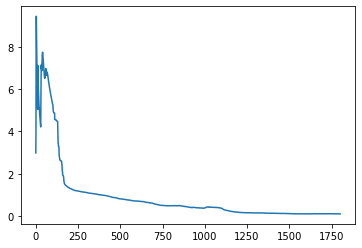

validation accuracy : 0.8375


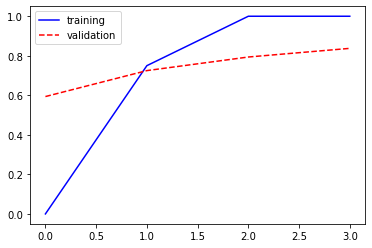

e= 92 15.777458906173706 seconds
e= 93 30.114022254943848 seconds
e= 94 44.39270091056824 seconds
e= 95 58.623064041137695 seconds
e= 96 72.84579610824585 seconds
e= 97 87.07905626296997 seconds
e= 98 101.32552814483643 seconds
e= 99 115.52685308456421 seconds
e= 100 129.70383310317993 seconds


In [38]:
net = train(net, loader_target_train, loader_target_test, criteria, optimizer, epochs, scheduler)

In [15]:
torch.save(net.state_dict(), output_path + "target_train.pt" )

Iteration Number 0 0.8777849674224854 seconds
Train (epoch 1/100) [0/20 (0%)]	Loss: 2.448123	Accuracy: 0.1875	Learning Rate:1e-05


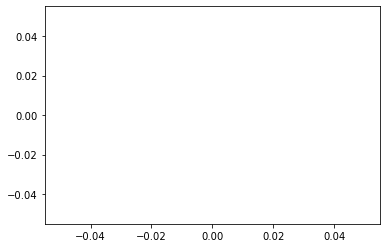

validation accuracy : 0.0


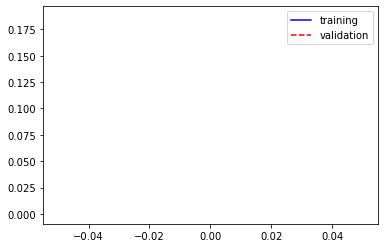

e= 2 16.671914100646973 seconds
e= 3 30.309196949005127 seconds
e= 4 46.82207274436951 seconds
e= 5 62.915690898895264 seconds
e= 6 78.23962092399597 seconds
e= 7 92.86025810241699 seconds
e= 8 107.6857979297638 seconds
e= 9 121.82084393501282 seconds
e= 10 136.64750003814697 seconds
e= 11 150.5344738960266 seconds
e= 12 164.09453010559082 seconds
e= 13 177.6281759738922 seconds
e= 14 191.14084577560425 seconds
e= 15 204.65601110458374 seconds
e= 16 219.06669688224792 seconds
e= 17 232.93046307563782 seconds
e= 18 247.53716897964478 seconds


In [ ]:
net_random = Load_model()
net_random = train(net_random, loader_random_source, loader_target_test, criteria, optimizer, epochs, scheduler)
torch.save(net_random.state_dict(), output_path + "random_source" )